# Projeto - Árvore KD
__Estrutura de Dados e Algoritmos - EMAp__

__Giovani de Almeida Valdrghi__

__Professor: Jean Roberto Ponciano__



## 1.Descrição

__Problema__: Seu cliente quer adquirir uma fazenda produtora de morangos e quer ter o melhor retorno possível. Seu serviço é oferecer um meio de informá-lo sobre as fazendas à venda que se encaixam nas características que ele deseja para que ele tome a melhor decisão. Fatores como produção mensal de morangos (500kg a 900kg/mês), área da propriedade (40 a 100 hectares) e valor de venda (1 milhão a 5 milhões de reais) são cruciais para a escolha dele. O que
ele quer é que você recomende algumas opções que melhor atendam aos valores informados por ele para essas três características. Com base nas opções elencadas, ele comprará a fazenda mais barata dentre as duas mais próximas ao local onde ele mora.

1. O cliente informará  uma fazenda "ideal" e a quantidade de opções que interessa a ele ($6 \leq x \leq 10$).
2. Exibiremos em ordem da mais semelhante até a menos semelhante. 
3. Informar quais as duas, dentre as $x$ fazendas que podem atendê-lo,
são mais próximas o local de moradia dele.


Para resolver o problema usaremos duas árvores KD diferentes, uma árvore inicialmente considerando as três primeiras características de uma fazenda (produção de morango, área, preço) para pesquisar as $x$ as mais próximas da fazenda "ideal", e em seguida contruíremos uma segunda árvore com essa $x$ fazendas porém utilizando os valores de longitude e latitude.

Para calcular a distância será utilizado a distância euclidiana, no entanto, na primeira árvore pela mudança de escala entre as características, iremos inicialmente normalizar as características para adicionar à arvore.




In [ ]:
#install graphviz
!apt install -y graphviz
!pip install graphviz

In [2]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import json
from graphviz import Digraph
import pandas as pd

## 2.Implementação

Serão três estruturas utilizadas para resolver o problema: KD tree, node e bounded priority queue.



### 2.1Bounded Priority Queue

A bounded priority queue será utilizada na pesquisa dos $x$ vizinhos mais próximos. A estrutura _heapq_ do Python será modificada para que ela aceite um total de $x$ elementos, removendo aquelas com menor prioridade. A prioridade será a distância euclidiana com a fazenda pesquisada, a prioridade no entanto é aquela elemento com o menor valor, por isso adicionaremos o negativo da distância na estrutura.

In [3]:
class BoundedQueue:
    """
    Bounded priority queue with max length equals to [self.max_size].
    The elements are inside the list self.items.
    self.items[0] contain the element with lowest dist.
    """
    def __init__(self, max_size):
        self.items = []
        self.size = 0
        self.max_size = max_size
    
    def add(self, node, dist):
        """Add a new element of the list (if there is size)."""
        heapq.heappush(self.items, (dist, node))
        self.size += 1
        
        if self.size > self.max_size:
            heapq.heappop(self.items)
            self.size -=1

    def is_full(self):
        """Check if queue is full."""
        return self.size == self.max_size

    def max_priority(self):
        """Return the priority of the element with max priority."""
        return self.items[0][0]

### 2.2 Node

O Node será o nó que irá compor a árvore, ele irá armazenar um numpy array que representa o ponto, o valor inteiro $k$ que é a dimensão em que ele será analisado na hora de comparação, além disso irá conter uma referência para os filhos. O ponto do nó pode possuir qualquer quantidade de valores, em uma árvore KD de dimensão $k$ apenas os primeiros $k$ valores do ponto serão relevantes.

In [4]:
class Node:
    """Node of KD-Tree, the value k is the dimension of lookup of the node."""
    def __init__(self, point, k = 0):
        self.point = np.array(point)
        self.k = k
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.point[0] < other.point[0]

### 2.3 KD-Tree

A estrutura principal, será a árvore KD com funções para inserção de um ponto, inserção de vários pontos balanceados, pesquisa de k vizinhos mais próximos e plot. Todas as funções seguirão uma lógica de recursividade para percorrer a árvore.

__Inserção:__ ambas funções assumem que recebem pontos únicos, e iniciam percorrendo a árvore pelo nó raiz. A inserção __balanceada__ utiliza o algoritmo de em cada sub-árvore ordenar os pontos pela dimensão de referência para o nível, e adicionar o ponto mediano no nó.

__Pesquisa k vizinhos__: função utiliza a estrutura já definida da fila de prioridade, percorre a árvore buscando pelos vizinhos mais próximos, mas não busca em sub-árvores que a distância seja maior do que a distância obtida pelo $k$-ésimo mais próximo até então, a menos que a fila de prioridade ainda não esteja cheia.

__Plot__: função utiliza da biblioteca graphviz para gerar um gráfico representativo da estrutura.



In [5]:
class KDTree:
    """
    Class of KD-Tree with points of dimension equals to [self.dim].
    """
    def __init__(self, dim):
        self.dim = dim
        self.root = None
        self.precision = 10

    def plot(self, precision = None):
        if precision != None:
            self.precision = precision
        """Plot the tree structure with values."""
        self.fig = Digraph(node_attr={'shape': 'plaintext'})
        self.update_plot()
        return self.fig

    def update_plot(self, curNode = -1, name = ""):
        """Recursive walk the tree adding new nodes to the graph."""
        
        #If this is the first call of intersetion, start at the root
        if curNode == -1:
            name = "r"
            curNode = self.root
        
        if curNode != None:
            self.fig.node(name, str(np.round(curNode.point[:self.dim], self.precision)))
            if name != 'r':
                self.fig.edge(name[:-1], name)
            self.update_plot(curNode.left, name + "l")
            self.update_plot(curNode.right, name + "r")
        
    def insert(self, point, curNode = -1):
        """
        Recursive insertion function, starts at the root, 
        walks the structure verifying if what side to follows.
        Assumes all points are different.
        """
        #It the tree is empty, create the root node
        if self.root == None:
            self.root = Node(point, k = 0)
            return

        #If this is the first call of intersetion, start at the root
        if curNode == -1:
            curNode = self.root
        
        k = curNode.k
        #New point is on left subtree
        if point[k] < curNode.point[k]:
            #if child exists, call recursive
            if curNode.left != None:
                self.insert(point, curNode.left)
            #if child don't exists, create child
            else:
                curNode.left = Node(point, k = (k + 1)%self.dim)
        #New point is on right subtree
        else:
            #if child exists, call recursive
            if curNode.right != None:
                self.insert(point, curNode.right)
            #if child don't exists, create child
            else:
                curNode.right = Node(point, k = (k + 1)%self.dim)

    def insert_many(self, points, curNode = -1, k = None):
        """
        Recursive function to add many points to the tree in a balanced manner.

        Inputs:
            points - numpy array of size [m, self.dim + q]
            curNode - Node to check if will have subtrees
            k - int dimension to sort
        """
        m = len(points)
        if curNode == -1:
            k = 0
            points = points[points[:, 0].argsort()] #Sort
            self.root = Node(points[m//2, :], k) #Add the middle to the root
            curNode = self.root

        #Separate in left, right, and sort
        k = (k + 1)%self.dim
        left_points = points[:m//2, :]
        left_points = left_points[left_points[:, k].argsort()]
        right_points = points[m//2+1:]
        right_points = right_points[right_points[:, k].argsort()]

        #Check if there will be a subtree, add the subtree        
        if left_points.shape[0] > 0:
            curNode.left = Node(left_points[len(left_points)//2, :], k)
        if right_points.shape[0] > 0:
            curNode.right = Node(right_points[len(right_points)//2, :], k)

        #Check if it is necessary to call recursive
        if left_points.shape[0] > 1:
            self.insert_many(left_points, curNode.left, k)
        if right_points.shape[0] > 1:
            self.insert_many(right_points, curNode.right, k)


    def k_neighbors(self, point, k):
        """
        Search for the [k] closest neighbors of [point] in the tree.
        Start the bounded priority queue and call the rescursive search.
        
        Inputs:
            point - numpy array of dim [self.dim + q]
            k - int, number of neighbors
        """
        candidates = BoundedQueue(k)
        curNode = self.root
        self.recursive_search(point, curNode, candidates)
        result = candidates.items
        #Sort candidates based on distance
        result = [(-dist, node.point) for dist, node in result]
        result.sort(key = lambda x : x[0])
        neighbors = [x[1] for x in result]
        dists = [x[0] for x in result]
        return neighbors, dists

    def recursive_search(self, point, curNode, candidates):
        """
        Recursive function to search for k neighbors.

        Inputs:
            point - numpy array of dim [self.dim + q]
            curNode - Node of current search
            candidates - bounded priority queue
        """
        if curNode == None:
            return
        
        dist = np.sqrt(np.square(point[:self.dim] - curNode.point[:self.dim]).sum())
        candidates.add(curNode, -dist) 

        #Decide the side to search
        k = curNode.k
        search_left = False
        if point[k] < curNode.point[k]:
            search_left = True
            self.recursive_search(point, curNode.left, candidates)
        else:
            self.recursive_search(point, curNode.right, candidates)

        #Follow other side if necessary
        if (~(candidates.is_full()) | 
            (abs(point[k] - curNode.point[k]) <= -candidates.max_priority())):
            if search_left:
                self.recursive_search(point, curNode.right, candidates)
            else:
                self.recursive_search(point, curNode.left, candidates)


## 3.Problema

O problema é composto por diferentes etapas, descrevo agora as funções utilizadas para cada uma delas. 

Iniciamos com uma função que __gera fazendas aleatórias__ com as características distribuídas dentro dos intervalos definidos, a posição de cada fazenda é a posição de alguma capital brasileira escolhida aleatoriamente.

In [6]:
def create_random_farms(n):
    coordinates_cities = json.load(open("coordinates_cities.json", 'r'))
    coordinates_cities = list(coordinates_cities.values())
    #strawberry prod | area | price | longitude | latitude
    farms = np.random.uniform(size = (n, 5))
    farms[:, 0] = farms[:, 0]*400 + 500
    farms[:, 1] = farms[:, 1]*60 + 40
    farms[:, 2] = farms[:, 2]*4 + 1
    cities = np.random.randint(len(coordinates_cities), size = (n))
    farms[:, 3] = [coordinates_cities[x][0] for x in cities]
    farms[:, 4] = [coordinates_cities[x][1] for x in cities]
    return farms

Em seguida devemos ter uma função que __cria a primeira árvore__, a única operação distinta dessa construção é que ela deve normalizar as características para o intervalo $[0, 1]$ e retorna os limites utilizados para essa normalização (mínimo e máximo de cada atributo antes da normalização).

In [7]:
def create_first_tree(farms, balanced = True):
    dim = 3
    tree = KDTree(dim)
    #normalize each column to [0, 1]
    farms_normalized = farms.copy()
    ranges = [[farms[:, i].min(), farms[:, i].max()] for i in range(3)]
    for i in range(3):
        farms_normalized[:, i] = (farms[:, i] - ranges[i][0])/(ranges[i][1] - ranges[i][0])
    if balanced:
        tree.insert_many(farms_normalized)
    else:
        for i in range(farms.shape[0]):
            tree.insert(farms_normalized[i, :])
    return tree, ranges

A função para realizar a __primeira pesquisa__ deverá receber a fazenda objetivo, o número de fazendas desejadas para a pesquisa e também precisará dos limites computados pela função anterior para normalizar igualmente a fazenda pesquisada.

In [8]:
def search_first_tree(tree, farm, ranges, k):
    farm_normalized = farm.copy()
    for i in range(3):
        farm_normalized[i] = (farm[i] - ranges[i][0])/(ranges[i][1] - ranges[i][0])

    neighbors, dists = tree.k_neighbors(farm_normalized, k)
    neighbors = np.array(neighbors)
    for i in range(3):
        neighbors[:, i] =  neighbors[:, i]* (ranges[i][1] - ranges[i][0]) + ranges[i][0]
    return neighbors, dists

Em sequência, precisamos de uma função que __constrói a segunda árvore__ com o resultado da primeira pesquisa, a operação característica dessa função será que ela irá inverter as ordens das colunas para os primeiros valores das fazendas serem a longitude e a latitude.

In [9]:
def create_second_tree(farms, balanced = True):
    dim = 2
    tree = KDTree(dim)
    farms_inverted = farms.copy()
    farms_inverted[:, :2] = farms[:, -2:]
    farms_inverted[:, 2:] = farms[:, :3]
    if balanced:
        tree.insert_many(farms_inverted)
    else:
        for i in range(farms_inverted.shape[0]):
            tree.insert(farms_inverted[i, :])
    return tree

A função que realiza a __segunda pesquisa__ recebe a fazenda objetivo e inverte a ordem dela para que as primeiras características sejam a longitude e a latitude. Ela não precisa receber o valor $k$ de vizinhos desejados pois esse valor é fixo igual a $2$.

In [10]:
def search_second_tree(tree, farm):
    farm_inverted = farm.copy()
    farm_inverted[:2] = farm[-2:]
    farm_inverted[2:] = farm[:3]

    neighbors_inverted, dists = tree.k_neighbors(farm, 2) 
    neighbors_inverted = np.array(neighbors_inverted)

    neighbors = neighbors_inverted.copy()
    neighbors[:,:3] = neighbors_inverted[:,-3:]
    neighbors[:,3:] = neighbors_inverted[:,:2]
    return neighbors, dists

Por fim criamos uma rotina que executa todos os passos e exibe os resultados.

In [11]:
def complete_search(farms, farm, k, verbose = True):
    first_tree, ranges = create_first_tree(farms)
    first_neighbors, first_dists = search_first_tree(first_tree, farm, ranges, k)
    if verbose:
        print(f"My objective farm: {farm}")
        print("First search:")
        for i in range(len(first_dists)):
            print(f"Dist: {np.round(first_dists[i], 3)}, {first_neighbors[i, :]}")
    second_tree = create_second_tree(first_neighbors)
    second_neighbors, second_dists = search_second_tree(second_tree, farm)
    if verbose:
        print("Second search:")
        for i in range(len(second_dists)):
            print(f"Dist: {np.round(second_dists[i], 3)}, {second_neighbors[i, :]}")

### 3.1 Exemplo

Exemplo de pesquisa com 50 fazendas, a fazenda objetivo tem produção de morangos igual a $600$kg, um total de $65$ hectares e um custo de $3$ milhões. As coordenadas são de uma cidade do interior de São Paulo.

In [12]:
farms = create_random_farms(50)
coordinates_my_city = [-47.74361, -23.165]
farm = np.array([600, 65, 3, coordinates_my_city[0], coordinates_my_city[1]])
complete_search(farms, farm, 5)

My objective farm: [600.       65.        3.      -47.74361 -23.165  ]
First search:
Dist: 0.077, [594.62627514  62.65623306   3.24830423 -38.54305556  -3.71722222]
Dist: 0.172, [664.6487523   64.45791633   2.89750795 -54.64638889 -20.44277778]
Dist: 0.21, [611.43715404  59.12177897   2.29406672 -54.64638889 -20.44277778]
Dist: 0.249, [507.38404523  62.67693635   3.13291372 -67.81        -9.97472222]
Dist: 0.254, [612.00617914  58.52478149   3.87871108 -60.025       -3.10194444]
Second search:
Dist: 642.23, [594.62627514  62.65623306   3.24830423 -38.54305556  -3.71722222]
Dist: 660.199, [611.43715404  59.12177897   2.29406672 -54.64638889 -20.44277778]


## 4.Análise complexidade

Vamos analisar a complexidade de solução do problema variando o número de fazendas disponíveis para pesquisa e o número de opções que o fazendeiro deseja receber. Iremos computar o tempo para $(50, 100, 500, 1000, 5000, 10000, 50000)$ fazendas disponíveis pesquisando pelas $5$ mais próximas, em sequência, com um total de $1000$ fazendas iremos computar o tempo pela pesquisa das $(5, 10, 20, 30, 40, 50)$ mais próximas.

In [13]:
import time
running_times = []
n_ = [50, 100, 500, 1000, 5000, 10000, 50000]
coordinates_my_city = [-47.74361, -23.165]
farm = np.array([600, 65, 3, coordinates_my_city[0], coordinates_my_city[1]])
for n in n_:
    farms = create_random_farms(n)
    start = time.time()
    complete_search(farms, farm, 5, False)
    running_times.append(1000 *(time.time() - start))

n = 1000
k_  = [5, 10, 20, 30, 40, 50]
running_times_k = []
for k in k_:
    farms = create_random_farms(n)
    start = time.time()
    complete_search(farms, farm, k, False)
    running_times_k.append(1000 *(time.time() - start))

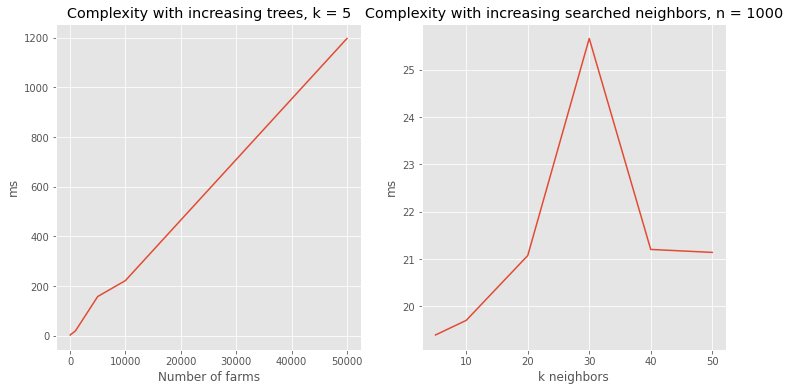

In [15]:
fig, ax = plt.subplots(nrows= 1, ncols = 2, figsize = (12, 6))
ax[0].plot(n_, running_times)
ax[0].set_title("Complexity with increasing trees, k = 5")
ax[0].set_ylabel("ms")
ax[0].set_xlabel("Number of farms")

ax[1].plot(k_, running_times_k)
ax[1].set_title("Complexity with increasing searched neighbors, n = 1000")
ax[1].set_ylabel("ms")
ax[1].set_xlabel("k neighbors")
plt.show()

## 5.Inserção balanceada

Apresento uma pequena comparação da construção de uma árvore balanceada, usando pontos aleatórios de duas dimensões, exibo primeiro a árvore resultado de inserção de pontos com a ordem aleatória e em sequência a mesma construção com algoritmo balanceado.

Simple insertion took: 0.356ms


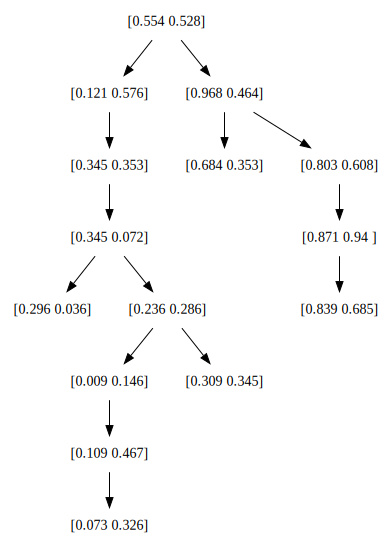

In [18]:
data = np.random.random((15, 2))
tree = KDTree(2)
start = time.time()
for i in range(15):
    tree.insert(data[i, :])
print(f"Simple insertion took: {1000* (time.time() - start):.3f}ms")
tree.plot(3)

Balanced insertion took: 1.456ms


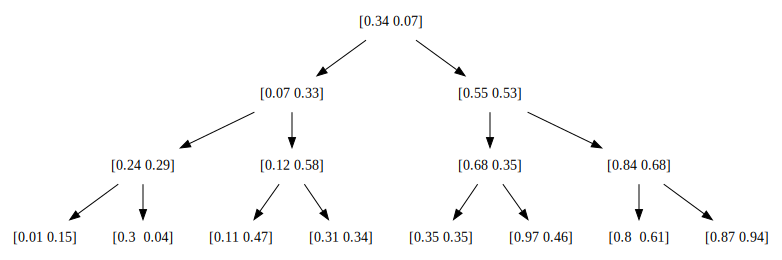

In [19]:
tree = KDTree(2)
start = time.time()
tree.insert_many(data)
print(f"Balanced insertion took: {1000* (time.time() - start):.3f}ms")
tree.plot(2)